In [1]:
import datetime
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import YahooDataProvider
import matplotlib.pyplot as plt
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.primitives import Sampler
from qiskit.circuit.library import RealAmplitudes
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np

In [2]:
def get_data(tickers, start_date, end_date):
    try:
        data = YahooDataProvider(tickers=tickers,
                                start=start_date,
                                end=end_date)
        data.run()
        return data
    except QiskitFinanceError as ex:
        print(ex)
        return None
    
def plot_data(data, ax, title):
    for (cnt, s) in enumerate(data._tickers):
        ax.plot(data._data[cnt], label=s)
    ax.legend(ncol=1,loc="upper center", bbox_to_anchor=(1, 1))
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid()

def fill_in_missing(data):
    for (cnt, s) in enumerate(data._tickers):
        print(f'{s}')
        print(f'Null values:{data._data[cnt].isnull().sum()}', end=' /')
        # Sustituir el valor NaN por el valor anterior
        data._data[cnt].interpolate(inplace=True)
        data._data[cnt].ffill(inplace=True)
        data._data[cnt].bfill(inplace=True)
        print(f' After:{data._data[cnt].isnull().sum()}')

def plot_covariance_matrix(sigma, ax, title):
    ax.imshow(sigma, interpolation="nearest")
    ax.set_title(title)

def plot_mu(data, mu, ax, title):
    # Plot the expected return in a lolipop plot
    ax.stem(mu)
    ax.set_xticks(range(len(mu)))
    ax.set_xticklabels(data._tickers, rotation=45)
    ax.set_xlabel("Stock")
    ax.set_ylabel("Expected return")
    ax.set_title(title)

def prepare_portfolio_optimization(risk_factor, budget, mu, sigma):
    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
    )
    qp = portfolio.to_quadratic_program()
    return portfolio, qp
    

def optimize(qp, ansatz, optimizer):
    svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer)
    svqe = MinimumEigenOptimizer(svqe_mes)
    result = svqe.solve(qp)
    return result

def interpret_results(result, portfolio, data):
    selected = portfolio.interpret(result)
    print("\tSelected stocks:")
    print("\t", end="")
    for s in selected:
        print(f" - {data._tickers[s]}", end="")
    print()
    print('\tExpected value: ',round(portfolio.portfolio_expected_value(result),5),end=" ")
    print('Variance: ',round(portfolio.portfolio_variance(result),5))

def get_interval_yearly(start_date, end_date):
    intervals = []
    for i in range(start_date.year, end_date.year+1):
        intervals.append((datetime.datetime(i,1,1), datetime.datetime(i,12,31)))
    return intervals
def get_interval_6months(start_date, end_date):
    intervals = []
    for i in range(start_date.year, end_date.year+1):
        intervals.append((datetime.datetime(i,1,1), datetime.datetime(i,6,30)))
        intervals.append((datetime.datetime(i,7,1), datetime.datetime(i,12,31)))
    return intervals
def get_interval_quarterly(start_date, end_date):
    intervals = []
    for i in range(start_date.year, end_date.year+1):
        intervals.append((datetime.datetime(i,1,1), datetime.datetime(i,3,31)))
        intervals.append((datetime.datetime(i,4,1), datetime.datetime(i,6,30)))
        intervals.append((datetime.datetime(i,7,1), datetime.datetime(i,9,30)))
        intervals.append((datetime.datetime(i,10,1), datetime.datetime(i,12,31)))
    return intervals

In [3]:
# ibex35, s&p500, nasdaq, FTSE 100, Nikkei 225, DAX, CAC 40, Hang Seng Index, Shanghai Composite, eurostoxx50, bovespa, omx stockholm 30, aex, moex

ticker_names = {
    # Indexes
    '^IBEX' : 'IBEX 35',
    '^GSPC' : 'S&P 500',
    '^IXIC' : 'Nasdaq',
    '^FTSE' : 'FTSE 100',
    '^N225' : 'Nikkei 225',
    '^GDAXI' : 'DAX',
    '^FCHI' : 'CAC 40',
    '^HSI' : 'Hang Seng Index',
    '000001.SS' : 'Shanghai Composite',
    '^STOXX50E' : 'Eurostoxx 50',
    '^BVSP' : 'Bovespa',
    '^OMX' : 'OMX Stockholm 30',
    '^AEX' : 'AEX',
    'IMOEX.ME' : 'MOEX'
}

In [4]:
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

In [5]:
intervals =[(start_date, end_date)]
#intervals = get_interval_quarterly(start_date, end_date)

for (i, interval) in enumerate(intervals):
    print(f"Intervalo {i+1}: {interval[0].date()} - {interval[1].date()}", end=" ")
    if i%4 == 0:
        print()

Intervalo 1: 2014-01-01 - 2023-12-31 


In [6]:
data_set = []
for start_date, end_date in intervals:
    data = get_data(list(ticker_names.keys()), start_date, end_date)
    data_set.append(data)

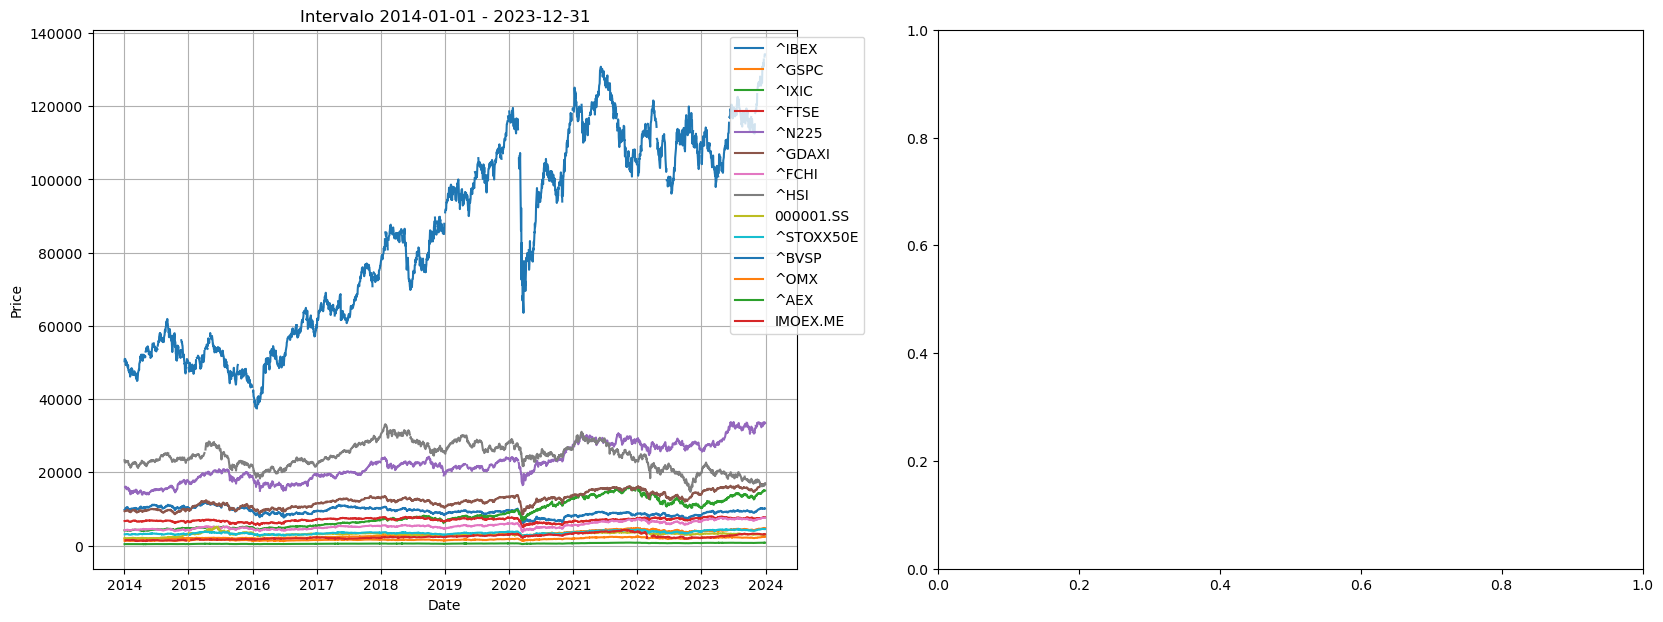

In [7]:
n_cols = 2
n_rows = max(len(data_set) // n_cols,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7*n_rows))

for data, interval in zip(data_set, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_data(data, axs[j], title)
    else:
        plot_data(data, axs[i, j], title)

In [8]:
# Fill if missing values
for data, interval in zip(data_set, intervals):
    print(f"Intervalo {interval[0].date()} - {interval[1].date()}")
    fill_in_missing(data)


Intervalo 2014-01-01 - 2023-12-31
^IBEX
Null values:44 / After:0
^GSPC
Null values:85 / After:0
^IXIC
Null values:85 / After:0
^FTSE
Null values:77 / After:0
^N225
Null values:157 / After:0
^GDAXI
Null values:66 / After:0
^FCHI
Null values:42 / After:0
^HSI
Null values:140 / After:0
000001.SS
Null values:170 / After:0
^STOXX50E
Null values:90 / After:0
^BVSP
Null values:125 / After:0
^OMX
Null values:92 / After:0
^AEX
Null values:42 / After:0
IMOEX.ME
Null values:141 / After:0


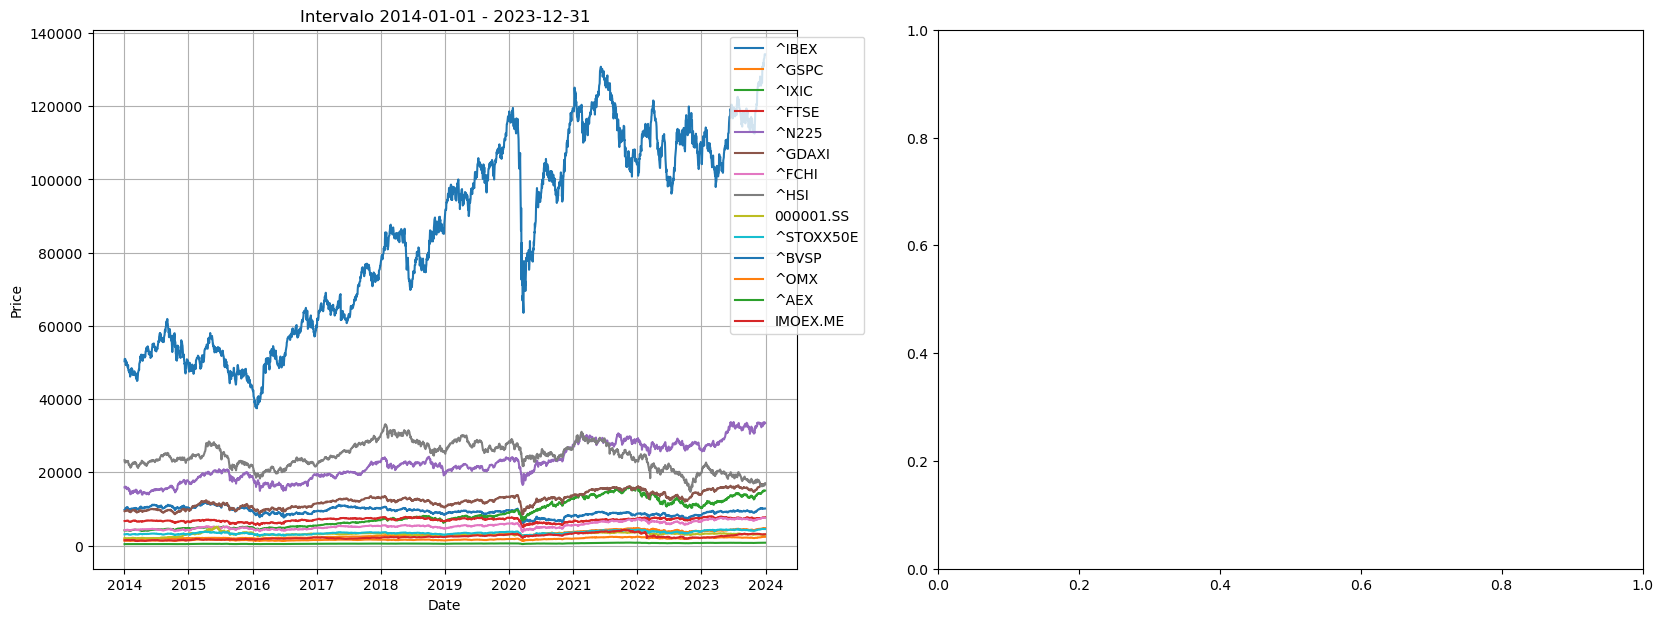

In [9]:
n_cols = 2
n_rows = max(len(data_set) // n_cols,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7*n_rows))

for data, interval in zip(data_set, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_data(data, axs[j], title)
    else:
        plot_data(data, axs[i, j], title)

In [10]:
# Coger las mus y sigmas de cada intervalo
mus = []
sigmas = []
for data, interval in zip(data_set, intervals):
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    print("Expected returns")
    print(mu)
    mus.append(mu)
    sigmas.append(sigma)

Intervalo 2014-01-01 - 2023-12-31
Expected returns
[ 9.03114832e-05  4.27880209e-04  5.79229831e-04  1.01933805e-04
  3.56915373e-04  2.95466649e-04  2.92876661e-04 -4.39102020e-05
  2.07960267e-04  2.20430764e-04  4.91832095e-04  2.89264930e-04
  3.19373011e-04  3.84964818e-04]


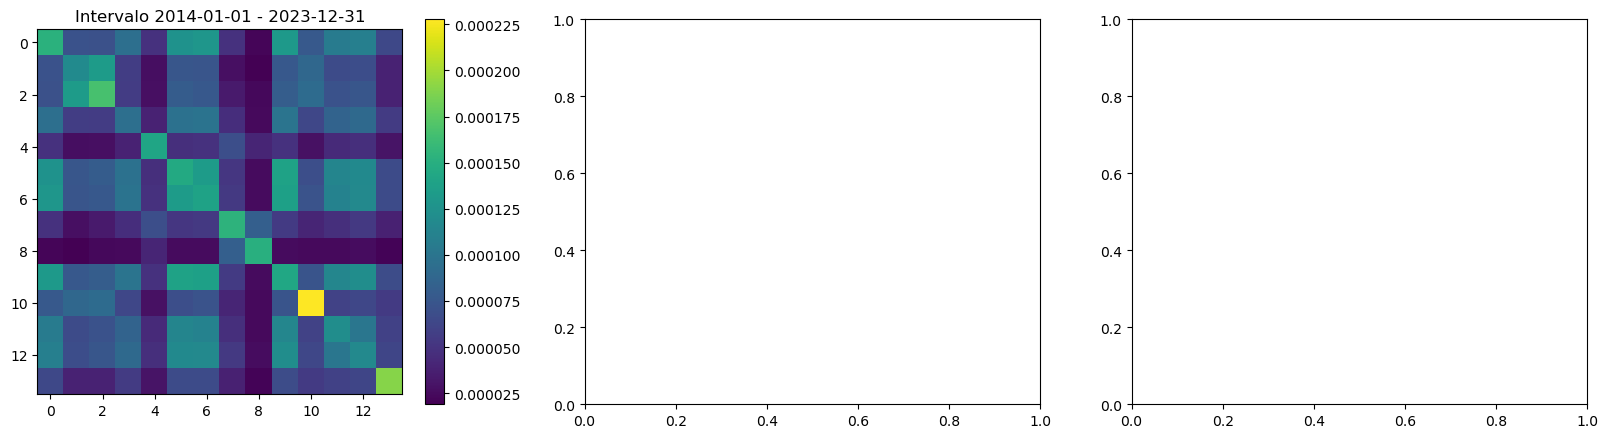

In [11]:
n_cols = 3
n_rows = max(len(sigmas) // n_cols + 1,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
for sigma, interval in zip(sigmas, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_covariance_matrix(sigma, axs[j], title)
        fig.colorbar(axs[j].imshow(sigma, interpolation="nearest"), ax=axs[j])
    else:
        plot_covariance_matrix(sigma, axs[i, j], title)
        fig.colorbar(axs[i, j].imshow(sigma, interpolation="nearest"), ax=axs[i, j])

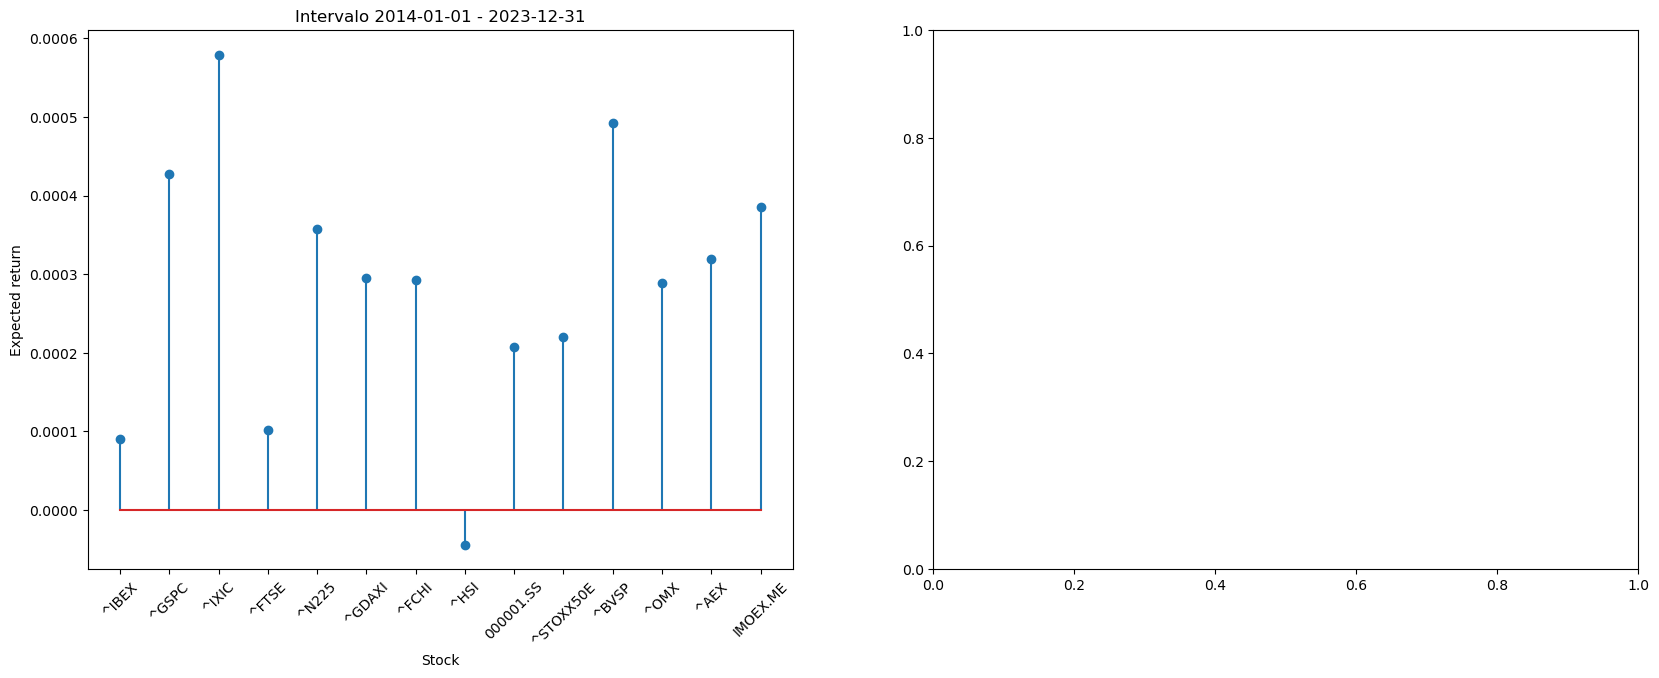

In [12]:
n_cols = 2
n_rows = max(len(mus) // n_cols,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7*n_rows))

for mu, interval in zip(mus, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_mu(data, mu, axs[j], title)
    else:
        plot_mu(data, mu, axs[i, j], title)

In [13]:
q = 0.5 # set risk factor
num_assets = len(ticker_names)
budget = num_assets // 3  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolios = []
quad_programs = []
for mu, sigma, interval in zip(mus, sigmas, intervals):
    portfolio, qp = prepare_portfolio_optimization(q, budget, mu, sigma)
    portfolios.append(portfolio)
    quad_programs.append(qp)
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    print(qp.prettyprint())

Intervalo 2014-01-01 - 2023-12-31
Problem name: Portfolio optimization

Minimize
  7.636164564320616e-05*x_0^2 + 7.141344348956453e-05*x_0*x_1
  + 7.751508497487717e-05*x_0*x_10 + 0.00010581268244076972*x_0*x_11
  + 0.00010886796478999006*x_0*x_12 + 6.448685740593086e-05*x_0*x_13
  + 7.102920649536532e-05*x_0*x_2 + 9.496405177784977e-05*x_0*x_3
  + 4.863626109382309e-05*x_0*x_4 + 0.00012538988359881537*x_0*x_5
  + 0.0001284316216928237*x_0*x_6 + 4.8883155676320365e-05*x_0*x_7
  + 2.1901073143161374e-05*x_0*x_8 + 0.00013233754940158692*x_0*x_9
  + 5.950823542778368e-05*x_1^2 + 8.843156347002778e-05*x_1*x_10
  + 6.636788249169007e-05*x_1*x_11 + 6.820843860135621e-05*x_1*x_12
  + 3.898977129444252e-05*x_1*x_13 + 0.00013356543695391442*x_1*x_2
  + 5.731278432245104e-05*x_1*x_3 + 2.6747441093200702e-05*x_1*x_4
  + 7.510363785863393e-05*x_1*x_5 + 7.387220824585722e-05*x_1*x_6
  + 2.765905170987858e-05*x_1*x_7 + 1.9004977038228087e-05*x_1*x_8
  + 7.609467503764001e-05*x_1*x_9 + 0.000113870099

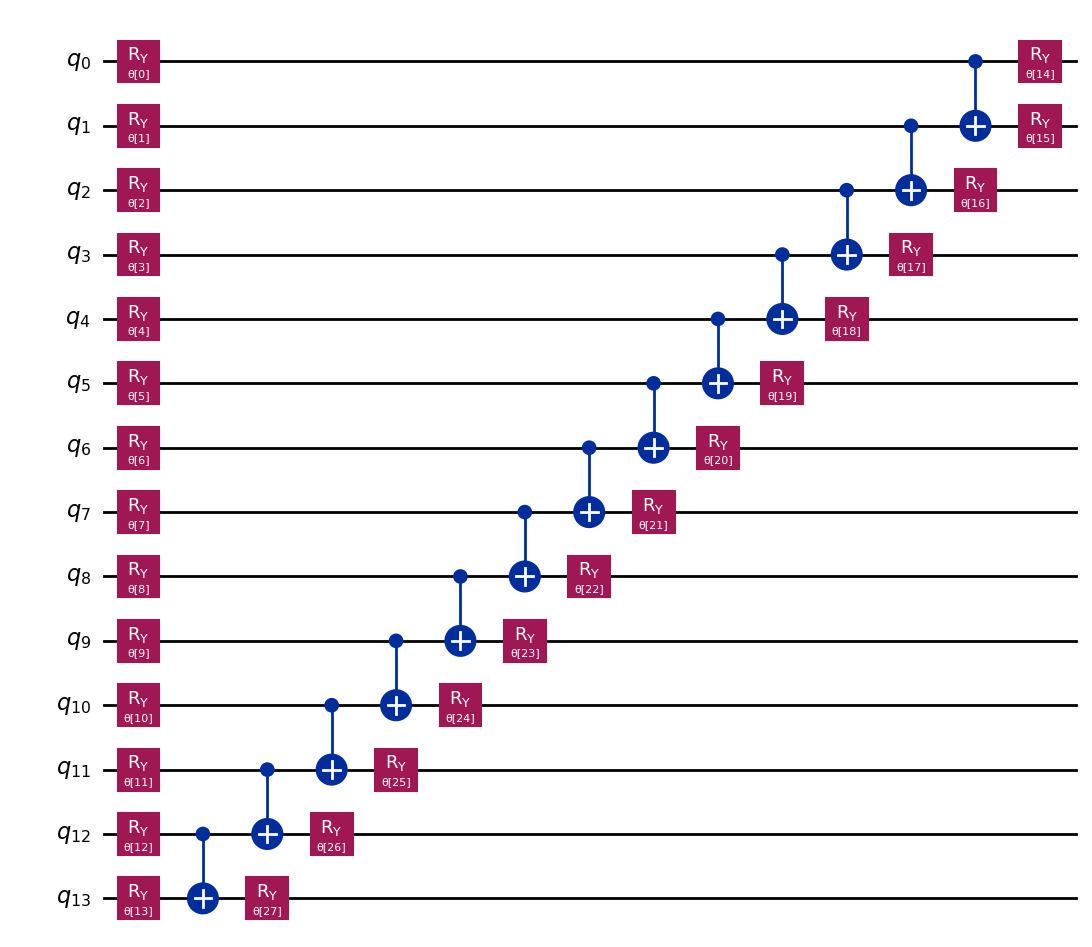

In [14]:
cobyla = COBYLA(maxiter=200)
ansatz = RealAmplitudes(num_assets, reps=1)
ansatz.decompose().draw(output="mpl",fold=-1)

In [15]:
results = []
for qp, interval in zip(quad_programs, intervals):
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    result = optimize(qp, ansatz, cobyla)
    results.append(result)
    print(result)

Intervalo 2014-01-01 - 2023-12-31
fval=-0.001087201055815001, x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=0.0, x_10=1.0, x_11=0.0, x_12=1.0, x_13=0.0, status=SUCCESS


In [16]:
for result, portfolio, data, interval in zip(results, portfolios, data_set, intervals):
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    interpret_results(result, portfolio, data)


Intervalo 2014-01-01 - 2023-12-31
	Selected stocks:
	 - ^IXIC - ^N225 - ^BVSP - ^AEX
	Expected value:  0.00175 Variance:  0.00132


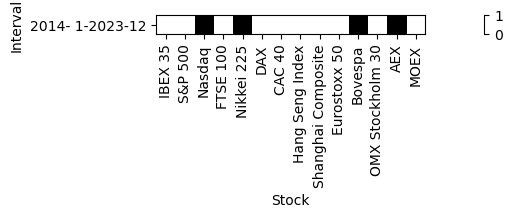

In [17]:
xs = [res.x for res in results]
# Plot the evolution of the portfolio as a bit map
plt.figure(figsize=(15, 0.25*len(xs)))
plt.imshow(xs, interpolation="nearest", cmap="Greys")
plt.xlabel("Stock")
plt.ylabel("Interval")
plt.xticks(range(len(ticker_names)), ticker_names.values(), rotation=90)
plt.yticks(range(len(xs)), [f"{interval[0].year}-{interval[0].month:2d}-{interval[1].year}-{interval[1].month:2d}" for interval in intervals])
plt.colorbar()
plt.show()

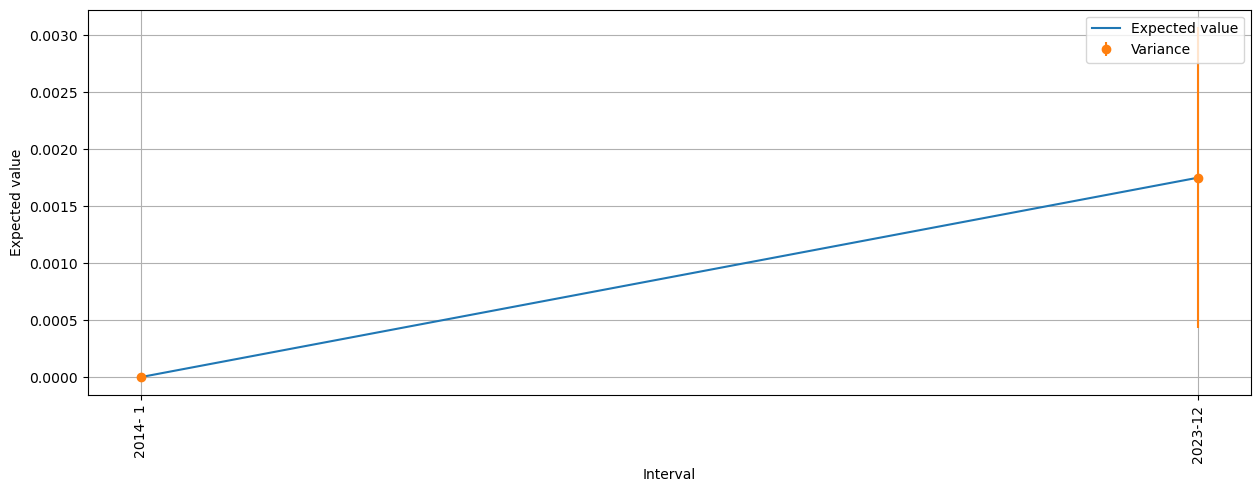

In [18]:
# Plot the progress of the expected value 
ys = [portfolio.portfolio_expected_value(res) for res in results]
vs = [portfolio.portfolio_variance(res) for res in results]
intervals2 = intervals.copy()

# Añadir valor inicial
ys.insert(0, 0)
vs.insert(0, 0)
intervals2.insert(0, (datetime.datetime(2014, 1, 1), datetime.datetime(2014, 1, 1)))

sds = [np.sqrt(v) for v in vs]

plt.figure(figsize=(15, 5))
# Plot the expected value
plt.plot(ys)
# Plot the variance as error bars
plt.errorbar(range(len(ys)), ys, yerr=vs, fmt="o")
plt.xlabel("Interval")
plt.ylabel("Expected value")
plt.xticks(range(len(ys)), [f"{interval[1].year}-{interval[1].month:2d}" for interval in intervals2], rotation=90)
plt.grid()
# Legend
plt.legend(["Expected value", "Variance"])
plt.show()